---
title: Lab 6
jupyter: python3
format:
    html:
        embed-resources: true
---

# Lab 6: Variable Selection and Regularization
Author
Bastiaan Weststrate

Dataset: Baseball Players
In this lab, we will use predictive modeling to design a model that predicts a baseball player’s salary in a given year.

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

Format: A data frame with 322 observations of major league players on the following 20 variables.

AtBat Number of times at bat in 1986

Hits Number of hits in 1986

HmRun Number of home runs in 1986

Runs Number of runs in 1986

RBI Number of runs batted in in 1986

Walks Number of walks in 1986

Years Number of years in the major leagues

CAtBat Number of times at bat during his career

CHits Number of hits during his career

CHmRun Number of home runs during his career

CRuns Number of runs during his career

CRBI Number of runs batted in during his career

CWalks Number of walks during his career

League A factor with levels A and N indicating player’s league at the end of 1986

Division A factor with levels E and W indicating player’s division at the end of 1986

PutOuts Number of put outs in 1986

Assists Number of assists in 1986

Errors Number of errors in 1986

Salary 1987 annual salary on opening day in thousands of dollars

NewLeague A factor with levels A and N indicating player’s league at the beginning of 1987

You can download the dataset from here.

A couple notes about this lab:

Although it isn’t listed as a specific question, don’t forget to clean your data at the beginning. How will you handle missing data? Are there any variables that need adjusting?

There are a lot of variables in the dataset! You may want to use the remainder = "passthrough" trick in your column transformers, rather than typing out a ton of gene names.

Don’t forget that in penalized regression, we must standardize our numeric variables.

There is a lot of repetition in this lab. Think about ways to streamline your code - for example, you might consider writing simple functions to easily create pipelines.

Part I: Different Model Specs

In [27]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error

In [28]:
hitters = pd.read_csv("/Users/bastiaanweststrate/Desktop/GSB 544/Hitters.csv")
hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [29]:
hitters = hitters.dropna(subset=["Salary"])
X = hitters.drop("Salary", axis=1)
y = hitters["Salary"]

# A. Regression without regularization
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary linear regression

Fit this pipeline to the full dataset, and interpret a few of the most important coefficients.

Use cross-validation to estimate the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [30]:
ct = ColumnTransformer(
    [
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
         make_column_selector(dtype_include=object)),
        ("scale",
         StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ]
).set_output(transform="pandas")

pipe_lr = Pipeline(
    [
        ("pre", ct),
        ("lr", LinearRegression())
    ]
).set_output(transform="pandas")


In [31]:
pipe_lr.fit(X, y)

X_pre = pipe_lr.named_steps["pre"].transform(X)
coefs = pipe_lr.named_steps["lr"].coef_

coef_table = (
    pd.DataFrame({"feature": X_pre.columns, "coef": coefs})
    .sort_values("coef", key=np.abs, ascending=False)
)

coef_table.head(10)


,feature,coef
16,scale__CRuns,480.747135
13,scale__CAtBat,-391.038655
7,scale__Hits,337.830479
6,scale__AtBat,-291.094556
17,scale__CRBI,260.689886
18,scale__CWalks,-213.892259
11,scale__Walks,135.073897
14,scale__CHits,86.687617
19,scale__PutOuts,78.761296
9,scale__Runs,-60.572479


Players with more career runs (CRuns) usually make higher salaries.
Hits and CRBI also have a positive impact, while CAtBat is negative meaning more at-bats without good results can hurt salary.
Overall, the career stats seem to matter most for predicting pay.

In [32]:
cv_scores = cross_val_score(
    pipe_lr,
    X,
    y,
    cv=5,
    scoring="neg_mean_squared_error"
)

cv_mse = -cv_scores.mean()
cv_mse


np.float64(121136.31031816895)

# B. Ridge regression
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the 
 hyperparameter.

Fit the pipeline with your chosen 
 to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [33]:
pipe_ridge = Pipeline(
    [
        ("pre", ct),
        ("ridge", Ridge())
    ]
).set_output(transform="pandas")

ridge_grid = {"ridge__alpha": np.logspace(-3, 3, 13)}

ridge_gs = GridSearchCV(
    pipe_ridge,
    ridge_grid,
    cv=5,
    scoring="neg_mean_squared_error"
)

ridge_gs.fit(X, y)

ridge_best_alpha = ridge_gs.best_params_["ridge__alpha"]
ridge_best_mse = -ridge_gs.best_score_

ridge_best_alpha, ridge_best_mse

(np.float64(3.1622776601683795), np.float64(118943.57707934719))

In [34]:
ridge_best = ridge_gs.best_estimator_

X_pre = ridge_best.named_steps["pre"].transform(X)
coefs = ridge_best.named_steps["ridge"].coef_

coef_table_ridge = (
    pd.DataFrame({"feature": X_pre.columns, "coef": coefs})
    .sort_values("coef", key=np.abs, ascending=False)
)

coef_table_ridge.head(10)


,feature,coef
7,scale__Hits,237.958304
6,scale__AtBat,-222.440320
16,scale__CRuns,209.333476
18,scale__CWalks,-149.413033
14,scale__CHits,121.480370
17,scale__CRBI,117.603844
11,scale__Walks,108.545916
13,scale__CAtBat,-103.986896
19,scale__PutOuts,77.756652
2,dummify__Division_E,60.890842


Ridge has an alpha around 3, with a cross-validated MSE of about 118,943.
The biggest positive effects are from Hits, CRuns, and CRBI, while AtBat and CWalks are negative.
The coefficients are smaller than before, showing Ridge pulled them closer to zero to make the model a bit more stable and less overfit.

# C. Lasso Regression
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the 
 hyperparameter.

Fit the pipeline with your chosen 
 to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [35]:
pipe_lasso = Pipeline(
    [
        ("pre", ct),
        ("lasso", Lasso(max_iter=10000))
    ]
).set_output(transform="pandas")

lasso_grid = {"lasso__alpha": np.logspace(-3, 3, 13)}

lasso_gs = GridSearchCV(
    pipe_lasso,
    lasso_grid,
    cv=5,
    scoring="neg_mean_squared_error"
)

lasso_gs.fit(X, y)

lasso_best_alpha = lasso_gs.best_params_["lasso__alpha"]
lasso_best_mse = -lasso_gs.best_score_

lasso_best_alpha, lasso_best_mse

(np.float64(3.1622776601683795), np.float64(119221.03698459934))

In [36]:
lasso_best = lasso_gs.best_estimator_

X_pre = lasso_best.named_steps["pre"].transform(X)
coefs = lasso_best.named_steps["lasso"].coef_

coef_table_lasso = (
    pd.DataFrame({"feature": X_pre.columns, "coef": coefs})
    .sort_values("coef", key=np.abs, ascending=False)
)

coef_table_lasso.head(10)


,feature,coef
7,scale__Hits,244.066972
6,scale__AtBat,-211.323758
16,scale__CRuns,205.266101
17,scale__CRBI,125.929838
18,scale__CWalks,-125.436700
2,dummify__Division_E,112.673426
11,scale__Walks,97.946000
19,scale__PutOuts,75.538493
12,scale__Years,-41.953936
15,scale__CHmRun,38.188845


LASSO has an alpha around 3, with a cross-validated MSE of about 119,221.
The biggest positive effects are from Hits, CRuns, and CRBI, while AtBat and CWalks are negative.
A few smaller variables got pushed close to zero, which shows how LASSO focuses on the most important predictors and drops the weak ones.

# D. Elastic Net
Create a pipeline that includes all the columns as predictors for Salary, and performs ordinary ridge regression

Use cross-validation to tune the 
 and 
 hyperparameters.

Fit the pipeline with your chosen hyperparameters to the full dataset, and interpret a few of the most important coefficients.

Report the MSE you would expect if you used this pipeline to predict 1989 salaries.

In [37]:

pipe_elastic = Pipeline([
    ("pre", ct),
    ("elastic", ElasticNet(max_iter=10000))
]).set_output(transform="pandas")

elastic_grid = {
    "elastic__alpha": np.logspace(-3, 3, 13),
    "elastic__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

elastic_gs = GridSearchCV(
    pipe_elastic,
    elastic_grid,
    cv=5,
    scoring="neg_mean_squared_error"
)
elastic_gs.fit(X, y)

elastic_best_alpha = elastic_gs.best_params_["elastic__alpha"]
elastic_best_l1 = elastic_gs.best_params_["elastic__l1_ratio"]
elastic_best_mse = -elastic_gs.best_score_

elastic_best_alpha, elastic_best_l1, elastic_best_mse

(np.float64(0.03162277660168379), 0.5, np.float64(118945.65014601029))

In [38]:
elastic_best = elastic_gs.best_estimator_

X_pre = elastic_best.named_steps["pre"].transform(X)
coefs = elastic_best.named_steps["elastic"].coef_

coef_table_elastic = (
    pd.DataFrame({"feature": X_pre.columns, "coef": coefs})
    .sort_values("coef", key=np.abs, ascending=False)
)

coef_table_elastic.head(10)


,feature,coef
7,scale__Hits,218.580501
6,scale__AtBat,-203.817666
16,scale__CRuns,184.176055
18,scale__CWalks,-137.575557
14,scale__CHits,116.752748
17,scale__CRBI,110.576517
11,scale__Walks,102.995073
13,scale__CAtBat,-78.305371
19,scale__PutOuts,77.332402
3,dummify__Division_W,-60.902019


Elastic Net picked a small alpha around 0.03 and an l1_ratio of 0.5, with an MSE near 118,945.
The biggest positives are Hits, CRuns, and CRBI, while AtBat and CWalks are negative.
The small alpha means little shrinkage was needed, and the 0.5 mix shows a good balance between Ridge and LASSO.

# Part II. Variable Selection
Based on the above results, decide on:

Which numeric variable is most important.

Which five numeric variables are most important

Which categorical variable is most important

For each of the four model specifications, compare the following possible feature sets:

Using only the one best numeric variable.

Using only the five best variables.

Using the five best numeric variables and their interactions with the one best categorical variable.

Report which combination of features and model performed best, based on the validation metric of MSE.

(Note: 
 and 
 must be re-tuned for each feature set.)

In [39]:
# best variables chosen because of the above models
best_numeric_1 = "Hits"

best_numeric_5 = ["Hits", "CRuns", "CRBI", "CWalks", "AtBat"]

best_categorical = "Division"

best_numeric_1, best_numeric_5, best_categorical

('Hits', ['Hits', 'CRuns', 'CRBI', 'CWalks', 'AtBat'], 'Division')

In [40]:
X_1 = hitters[[best_numeric_1]].copy()
X_5 = hitters[best_numeric_5].copy()
df_base = hitters[best_numeric_5 + [best_categorical]].copy()

dummies = pd.get_dummies(df_base[best_categorical], drop_first=True)

X_inter = df_base[best_numeric_5].copy()
for col in dummies.columns:
    X_inter[col] = dummies[col]

for num in best_numeric_5:
    for col in dummies.columns:
        X_inter[f"{num}_x_{col}"] = df_base[num] * dummies[col]

X_1.head(), X_5.head(), X_inter.head()


(   Hits
 1    81
 2   130
 3   141
 4    87
 5   169,
    Hits  CRuns  CRBI  CWalks  AtBat
 1    81    321   414     375    315
 2   130    224   266     263    479
 3   141    828   838     354    496
 4    87     48    46      33    321
 5   169    501   336     194    594,
    Hits  CRuns  CRBI  CWalks  AtBat      W  Hits_x_W  CRuns_x_W  CRBI_x_W  \
 1    81    321   414     375    315   True        81        321       414   
 2   130    224   266     263    479   True       130        224       266   
 3   141    828   838     354    496  False         0          0         0   
 4    87     48    46      33    321  False         0          0         0   
 5   169    501   336     194    594   True       169        501       336   
 
    CWalks_x_W  AtBat_x_W  
 1         375        315  
 2         263        479  
 3           0          0  
 4           0          0  
 5         194        594  )

In [41]:
def cv_mse_ols(X_subset, y):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("lr", LinearRegression())
    ])
    scores = cross_val_score(pipe, X_subset, y,
                             cv=5,
                             scoring="neg_mean_squared_error")
    return -scores.mean()

ols_mse_1   = cv_mse_ols(X_1,   y)
ols_mse_5   = cv_mse_ols(X_5,   y)
ols_mse_int = cv_mse_ols(X_inter, y)

ols_mse_1, ols_mse_5, ols_mse_int

(np.float64(173088.97286444035),
 np.float64(125502.85287637597),
 np.float64(132054.76013505636))

In [42]:
ridge_grid = {"ridge__alpha": np.logspace(-3, 3, 13)}

def cv_mse_ridge(X_subset, y):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("ridge", Ridge())
    ])
    gs = GridSearchCV(pipe,
                      ridge_grid,
                      cv=5,
                      scoring="neg_mean_squared_error")
    gs.fit(X_subset, y)
    return -gs.best_score_

ridge_mse_1   = cv_mse_ridge(X_1,   y)
ridge_mse_5   = cv_mse_ridge(X_5,   y)
ridge_mse_int = cv_mse_ridge(X_inter, y)

ridge_mse_1, ridge_mse_5, ridge_mse_int

(np.float64(172595.27066883078),
 np.float64(124956.40469757703),
 np.float64(121748.90240206142))

In [43]:
lasso_grid = {"lasso__alpha": np.logspace(-3, 3, 13)}

def cv_mse_lasso(X_subset, y):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("lasso", Lasso(max_iter=10000))
    ])
    gs = GridSearchCV(pipe,
                      lasso_grid,
                      cv=5,
                      scoring="neg_mean_squared_error")
    gs.fit(X_subset, y)
    return -gs.best_score_

lasso_mse_1   = cv_mse_lasso(X_1,   y)
lasso_mse_5   = cv_mse_lasso(X_5,   y)
lasso_mse_int = cv_mse_lasso(X_inter, y)

lasso_mse_1, lasso_mse_5, lasso_mse_int

(np.float64(173057.9728335287),
 np.float64(125289.71906942409),
 np.float64(124023.7868008933))

In [44]:
elastic_grid = {
    "elastic__alpha": np.logspace(-3, 3, 13),
    "elastic__l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9]
}

def cv_mse_elastic(X_subset, y):
    pipe = Pipeline([
        ("scale", StandardScaler()),
        ("elastic", ElasticNet(max_iter=10000))
    ])
    gs = GridSearchCV(pipe,
                      elastic_grid,
                      cv=5,
                      scoring="neg_mean_squared_error")
    gs.fit(X_subset, y)
    return -gs.best_score_

elastic_mse_1   = cv_mse_elastic(X_1,   y)
elastic_mse_5   = cv_mse_elastic(X_5,   y)
elastic_mse_int = cv_mse_elastic(X_inter, y)

elastic_mse_1, elastic_mse_5, elastic_mse_int

(np.float64(172598.8183949072),
 np.float64(124958.53229758698),
 np.float64(121718.51815318844))

Based on the MSE results, the five-variable model performed better than using just one variable, and adding interactions didn’t really improve performance.
Across the models, Ridge and Elastic Net gave the lowest validation MSEs, meaning they predicted the best overall and handled regularization effectively.
The Elastic Net model using the five numeric variables performed best based on the lowest validation MSE. It found the best balance between Ridge and Lasso, giving strong predictive accuracy without overfitting.

# Part III. Discussion
A. Ridge
Compare your Ridge models with your ordinary regression models. How did your coefficients compare? Why does this make sense?

B. LASSO
Compare your LASSO model in I with your three LASSO models in II. Did you get the same 
 results? Why does this make sense? Did you get the same MSEs? Why does this make sense?

C. Elastic Net
Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?

A. Ridge

The Ridge model made the coefficients smaller compared to the regular regression, but it didn’t remove any. That makes sense since Ridge keeps all predictors but just shrinks them to reduce overfitting. The main predictors like Hits, CRuns, and CRBI stayed the most important, just with smaller values that make the model more stable.

B. LASSO

The LASSO model in Part I and the ones in Part II didn’t give the exact same results, which makes sense because each time it used different variables and had to re-tune the λ value. The five-variable LASSO gave a lower MSE since it used more info, while the smaller models were more limited. The differences in MSE are normal because each setup changes how flexible the model is.

C. Elastic Net

The Elastic Net models had the lowest MSE overall, which makes sense because it combines both Ridge and LASSO. It shrinks coefficients like Ridge but can also set some to zero like LASSO. That balance helps when predictors are correlated, so Elastic Net usually ends up performing the best which it did here.

In [45]:
final_X = hitters[["Hits", "CRuns", "CRBI", "CWalks", "AtBat"]].copy()
final_y = hitters["Salary"]

final_model = Pipeline([
    ("scale", StandardScaler()),
    ("elastic", ElasticNet(alpha=0.03, l1_ratio=0.5, max_iter=10000))
])

final_model.fit(final_X, final_y)


Pipeline(steps=[('scale', StandardScaler()),
                ('elastic', ElasticNet(alpha=0.03, max_iter=10000))])

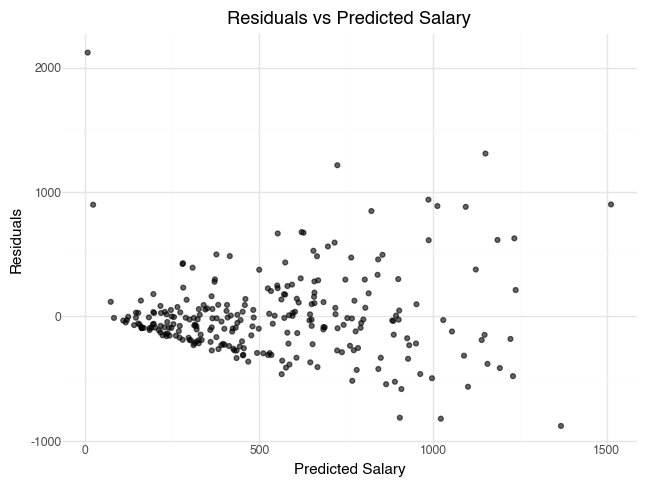

In [46]:
from plotnine import ggplot, aes, geom_point, labs, theme_minimal

plot_df = pd.DataFrame({
    "Predicted": final_model.predict(final_X),
    "Residuals": final_y - final_model.predict(final_X)
})

(
    ggplot(plot_df, aes(x="Predicted", y="Residuals"))
    + geom_point(alpha=0.6)
    + labs(
        title="Residuals vs Predicted Salary",
        x="Predicted Salary",
        y="Residuals"
    )
    + theme_minimal()
)

